In [2]:
import numpy as np
import sys, os, time
import matplotlib.pyplot as plt
from scipy import stats

from scipy.interpolate import griddata
from scipy.interpolate import interp1d
from scipy import interpolate
from mpl_toolkits import mplot3d
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
# from mat4py import loadmat

from pylab import figure, show
from mpl_toolkits.mplot3d import Axes3D

from scipy.stats import truncnorm
import numpy as np
from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import LightSource
from scipy.stats import gaussian_kde
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def get_u2(test, output_tensor, inputs_tensor, args, batchsize):
    # import ipdb; ipdb.set_trace()

    t0_u = test[:batchsize, inputs.shape[1] + 3 - 1:inputs.shape[1] + 5 - 1]
    tT_u = test[batchsize:2*batchsize, inputs.shape[1] + 3 - 1:inputs.shape[1] + 5 - 1]
    tt_u = test[2*batchsize:, inputs.shape[1] + 3 - 1:inputs.shape[1] + 5 - 1]
    print(
        np.max(t0_u),
        np.max(tT_u),
        np.max(tt_u)
    )

    return t0_u, tT_u, tt_u

In [4]:
def do_integration2(control_data, d, T_0, T_t, mu_0, sigma_0, args, sde, sde2):
    # dt = (T_t - T_0)/(args.bif)
    # ts = np.arange(T_0, T_t + dt, dt)
    ts = torch.linspace(T_0, T_t, int(T_t * 500), device=cuda0)
    # ts = torch.linspace(T_0, 1, int(1 * 500), device=cuda0)

    # import ipdb; ipdb.set_trace()

    initial_sample = np.random.multivariate_normal(
        np.array(mu_0), np.eye(d)*sigma_0, args.M) # 100 x 3

    print(sigma_0)

    v_scales = [float(x) for x in args.v_scale.split(",")]
    biases = [float(x) for x in args.bias.split(",")]

    ##############################

    all_results = {}

    mus = np.zeros(d*2)
    variances = np.zeros(d*2)

    without_control = np.empty(
        (
            initial_sample.shape[0],
            initial_sample.shape[1],
            len(ts),
        ))

    with_control = np.empty(
        (
            initial_sample.shape[0],
            initial_sample.shape[1],
            len(ts),
        ))

    initial_sample_tensor = torch.tensor(initial_sample,
        dtype=torch.float32, device=cuda0)

    # import ipdb; ipdb.set_trace()

    ts = ts.to(cuda0)

    for i in range(initial_sample_tensor.shape[0]):
        y0 = initial_sample_tensor[i, :]
        y0 = torch.reshape(y0, [1, -1])

        # import ipdb; ipdb.set_trace()

        bm = torchsde.BrownianInterval(
            t0=float(T_0),
            t1=float(T_t),
            size=y0.shape,
            device=cuda0,
        )  # We need space-time Levy area to use the SRK solver
        
        dt = 1/(T_t*500)
        dt = 0.01

        y_pred = torchsde.sdeint(sde, y0, ts, method='euler', bm=bm, dt=dt).squeeze()
        # calculate predictions
        without_control[i, :, :] = y_pred.detach().cpu().numpy().T

        y_pred = torchsde.sdeint(sde2, y0, ts, method='euler', bm=bm, dt=dt).squeeze()
        with_control[i, :, :] = y_pred.detach().cpu().numpy().T

        print(i)
        print(y0)
        print(y_pred[-1, :])

    for d_i in range(d):
        mus[2*d_i] = np.mean(with_control[:, d_i, -1])
        variances[2*d_i] = np.var(with_control[:, d_i, -1])

        mus[2*d_i+1] = np.mean(without_control[:, d_i, -1])
        variances[2*d_i+1] = np.var(without_control[:, d_i, -1])

    ts = ts.detach().cpu().numpy()

    return ts, initial_sample, with_control, without_control,\
        None, mus, variances

In [5]:
sys.path.insert(0,'./training/iman/')
from train import *

d = 2
batchsize = None

d = 2
N = 15
batchsize = None

mu_0 = [0.35, 0.35]

sigma = 0.1
T_t = 200.0
bcc = np.array([0.41235, 0.37605])

class Container(object):
    state_bound_min = 0.1
    state_bound_max = 0.6
    bound_u = 0

    bif = 100000
    batchsize2 = "5000"
    batch2_period = 5000
    batchsize = ""
    
    diff_on_cpu = 1
    grid_n = 30
    interp_mode = "nearest"
    
    M = 25
    v_scale = "1.0"
    bias = "1.0"
    
    testdat = './training/iman/test.dat'
    N = 15
    modelpt = './training/iman/tt200_2d_mse-15000.pt'
    modelpt = './training/iman/tt200_2dr0_mse-15000.pt'
    modelpt = './training/iman/tt200_2dr0_mse-15000.pt'
    
    sigma = sigma
    T_t = T_t
args = Container()

N = args.N

pytorch


Using backend: pytorch



True
1
NVIDIA RTX A2000 Laptop GPU
11.6
0
pytorch
trying
no SDE


/usr/local/home/cyan3/miniforge/envs/tf/lib/python3.9/site-packages/deepxde/backend/pytorch/tensor.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(initial_value, dtype=dtype, requires_grad=True)


In [6]:
test = np.loadtxt(args.testdat)

print("test.shape", test.shape)
d = test.shape[1] - 1 - 4 # one for time, 4 for pinn output
print("found %d dimension state space" % (d))
M = N**d

test.shape (5450, 7)
found 2 dimension state space


In [7]:
sys.path.insert(0, './sde/T_t200_2D')
from trained_sde_model import SDE

sde = SDE()

files = glob.glob(
    sde_path + "/*.pt", 
    recursive = False)
assert(len(files) == 1)
print("using model: ", files[0])
sde.load_state_dict(torch.load(files[0]))

if torch.cuda.is_available():
    print("Using GPU.")
    sde = sde.to(cuda0)
# set model to evaluation mode
sde.eval()
    
sde.r = torch.tensor(np.array([0.0]*2), dtype=torch.float32)
sde.r = sde.r.reshape([-1, 2])

test = np.loadtxt(args.testdat)
print("test.shape", test.shape)
d = test.shape[1] - 1 - 4 # one for time, 4 for pinn output
print("found %d dimension state space" % (d))
M = N**d

hello?
hello?
hello?
hello?
hello?
hello?
using model:  ./sde/T_t200_2D/15fold_3_2_layer_model.pt
Using GPU.
test.shape (5450, 7)
found 2 dimension state space


In [8]:

data = np.genfromtxt('./training/iman/test.dat')
points=data[:,0:2]
inputs=data[:,4].reshape(-1,1)
psi=data[:,2].reshape(-1,1)
print(inputs.shape)

fig, ax = plt.subplots(1,1)
ax.plot(points[:,1:2], points[:,0:1], '.')
ax.set_xlabel(r'$t$ [s]', fontsize=16)
ax.set_ylabel(r"$\langle C_{6} \rangle$ ", fontsize=16,rotation='horizontal')
ax.yaxis.set_label_coords(-0.07, 0.5)
ax.xaxis.set_label_coords(0.5, -.1)
plt.tight_layout()
fig.set_size_inches(8,4)
plt.show()

(5450, 1)


In [9]:
model, meshes = get_model(
    d,
    N,
    batchsize,
    0,
    "tanh",

    mu_0,
    sigma,

    bcc,
    sigma,

    T_t,
    args,
    sde.network_f,
    sde.network_g,
)
model.restore(args.modelpt)

abhishek
abhishek
abhishek
abhi
sampling domain by  5000
num_test NONE
hello?
hello?
hello?
hello?
hello?
Compiling model...
'compile' took 0.000079 s



In [10]:
inputs = np.float32(test[:, :d+1])

print("inputs.shape", inputs.shape)

inputs = np.vstack((
    model.data.bc_points(),
    model.data.train_x_all
))

print("inputs.shape", inputs.shape)

inputs.shape (5450, 3)
inputs.shape (5450, 3)


In [11]:
test, T_t,\
rho0, rhoT,\
bc_grids, domain_grids, grid_n_meshes,\
control_data = make_control_data(
    model, inputs, N, d, meshes, args, get_u2)

batchsize 225 inputs.shape (5450, 3) d 2
found T_t 200.0
keeping input on cpu
0.24377458 0.021743491 0.07564199
# tt_di nans: 0 0 54000
# tt_di nans: 1 0 54000


In [12]:
class SDE2(SDE):
    def __init__(self, control_data):
        super(SDE2, self).__init__()

        self.control_data = control_data

    def query_u(self, t, y):
        if torch.abs(t - 0) < 1e-8:
            t_key = 't0'
        elif torch.abs(t - 1.0) < 1e-8:
            t_key = 'tT'
        else:
            t_key = 'tt'
        t_control_data = self.control_data[t_key]

        query = y[0].detach().cpu().numpy()

        if t_control_data['grid'].shape[1] == 2 + 1:
            t2 = t.detach().cpu().numpy()
            query = np.append(query, t2)

        if 'grid_tree' in t_control_data:
            _, closest_grid_idx = t_control_data['grid_tree'].query(
                np.expand_dims(query, axis=0),
                k=1)
        else:
            closest_grid_idx = np.linalg.norm(
                query - t_control_data['grid'], ord=1, axis=1).argmin()

        u1 = t_control_data['0'][closest_grid_idx]
        u2 = t_control_data['1'][closest_grid_idx]

        u_tensor = torch.tensor(np.array([u1, u2]), dtype=torch.float32)
        u_tensor = u_tensor.reshape([-1, 2])

        return u_tensor

    # drift
    def f(self, t, y): # ~D1
        u_tensor = self.query_u(t, y)

        t = torch.reshape(t, [-1, 1])
        # need to cat the ramp rates on the input vector for y
        input_vec = torch.cat([y, u_tensor, t], axis=1)

        # print(self.network_f.forward(input_vec).shape)

        return self.network_f.forward(input_vec)

    # diffusion
    def g(self, t, y): # ~D2
        """
        Output of g: should be a single tensor of size
        (batch_size, d)
        """
        u_tensor = self.query_u(t, y)

        t = torch.reshape(t, [-1, 1])

        # need to cat the ramp rates on the input vector for g
        input_vec = torch.cat([y, u_tensor, t], axis=1)

        # print("g", self.network_g.forward(input_vec))

        return self.network_g.forward(input_vec)

sde2 = SDE2(control_data)

sde2.load_state_dict(torch.load(files[0]))
if torch.cuda.is_available():
    print("Using GPU.")
    sde2 = sde2.to(cuda0)
# set model to evaluation mode
sde2.eval()

hello?
hello?
hello?
hello?
hello?
hello?
Using GPU.


SDE2(
  (network_f): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=2, bias=True)
  )
  (network_g): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=2, bias=True)
  )
)

In [13]:
ts, initial_sample, with_control, without_control,\
    all_results, mus, variances = do_integration2(
        control_data, d, T_0, T_t, mu_0, args.sigma,
        args, sde, sde2)

0.1
0
tensor([[-0.471, -0.168]])
tensor([0.236, 0.359], grad_fn=<SliceBackward0>)
1
tensor([[0.660, 0.348]])
tensor([0.228, 0.364], grad_fn=<SliceBackward0>)
2
tensor([[0.468, 0.201]])
tensor([0.216, 0.365], grad_fn=<SliceBackward0>)
3
tensor([[0.480, 0.124]])
tensor([0.228, 0.368], grad_fn=<SliceBackward0>)
4
tensor([[ 0.765, -0.065]])
tensor([0.234, 0.364], grad_fn=<SliceBackward0>)
5
tensor([[0.377, 0.565]])
tensor([0.249, 0.364], grad_fn=<SliceBackward0>)
6
tensor([[0.464, 0.459]])
tensor([0.218, 0.370], grad_fn=<SliceBackward0>)
7
tensor([[0.065, 0.273]])
tensor([0.196, 0.363], grad_fn=<SliceBackward0>)
8
tensor([[ 0.917, -0.264]])
tensor([0.212, 0.357], grad_fn=<SliceBackward0>)
9
tensor([[ 0.189, -0.107]])
tensor([0.259, 0.359], grad_fn=<SliceBackward0>)
10
tensor([[0.345, 0.709]])
tensor([0.179, 0.361], grad_fn=<SliceBackward0>)
11
tensor([[0.524, 1.020]])
tensor([0.207, 0.362], grad_fn=<SliceBackward0>)
12
tensor([[-0.068, -0.101]])
tensor([0.247, 0.363], grad_fn=<SliceBackwar

In [14]:
for j in range(2):
    print(
        'with: %.2f, %.2f, without: %.2f, %.2f' % (
            mus[2*j], variances[2*j],
            mus[2*j+1], variances[2*j+1]))

with: 0.23, 0.00, without: 0.23, 0.00
with: 0.36, 0.00, without: 0.36, 0.00


In [15]:
with_control[0, :, :].shape

(2, 100000)

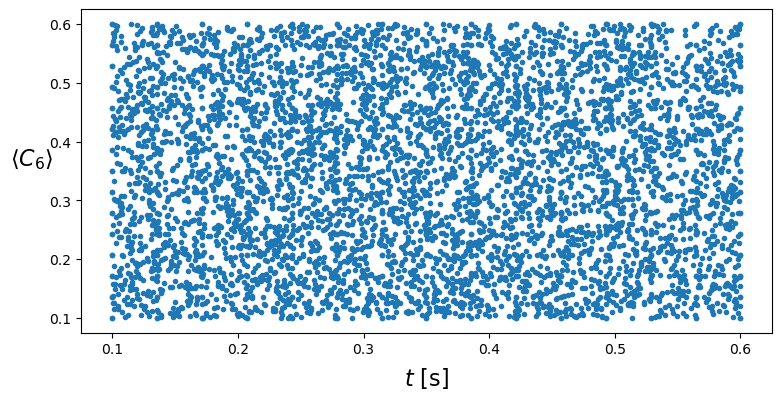

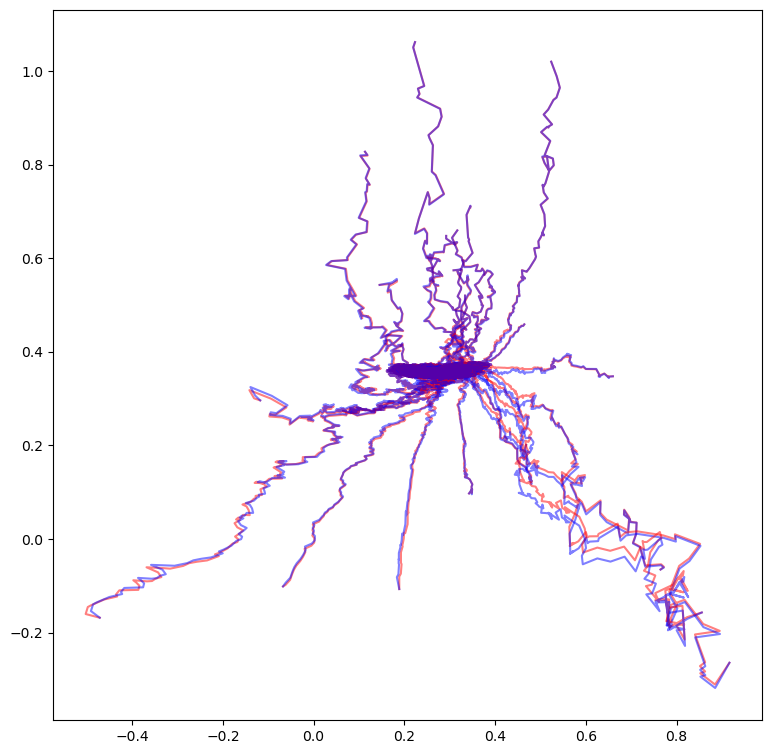

In [16]:
%matplotlib inline

fig, ax = plt.subplots(1,1)

for w in range(with_control.shape[0]):
    ax.plot(with_control[w, 0, :], with_control[w, 1, :], 'r', alpha=0.5)
    ax.plot(without_control[w, 0, :], without_control[w, 1, :], 'b', alpha=0.5)


plt.tight_layout()
fig.set_size_inches(8,8)
plt.show()